# Text Classification  -  Sentiment Analysis

##   Load required packages

In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV

from time import time
from sklearn import metrics

##  Load and prepare the data

### Load the data

In [9]:
# load the data
data = pd.read_csv("redoute_v3.csv")
data.head(2)

,id,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,...,year_of_transaction,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,...,2023,9,23,5,1,2023-09-23,1049,6.955593,7,12.0
1,rev-b54467c4-4769-42e3-a74a-c72c000059f9,4,Jolie table mais plus pour 6 que pour 8,Livraison impeccable avec possibilité de prend...,2023-10-02 13:08:27,2023-09-11,NaN,NaN,2023-10-02,2023,...,2023,9,11,0,0,2023-09-11,885,6.785588,39,21.0


### Prepare the data
We use NLTK to process the comment's text : 
- remove punctuation,
- remove numeric characters,
- remove stopwords

#### Clean the comment's text

In [10]:
# Clean comments : remove number, punctuation, keep only alphabetic string chains word length >= 2
# remove stop words
# and convert to lower case

#non_discrimant_words = ["redoute", "commande", "redoute", "achat","livraison", "article", "articles", "produit", "produits"]
added_stopwords = ["leur", "leurs", "avoir", "cela", "les", "de", "pour", "des", "cette", "a",
                   "jai", "car", "cest", "chez", "tout", "fait", "chez", "donc", 
                   "nest", "si", "alors", "nai", "faire", "deux", "comme", "jour", "tr", "si", "ue"]
stop_words = set(stopwords.words('french'))  | set(added_stopwords) #| set(non_discrimant_words)

def clean_text(txt):
    #keep only alphabetic string with lenght >= 2
    #tokenizer = RegexpTokenizer(r"[a-zA-Zéàèêùïîûç']{2,}")
    tokenizer = RegexpTokenizer(r"[^0-9#$%:/]{2,}")
    tokens = tokenizer.tokenize(txt.lower())
    txt_cleaned = ""
    for mot in tokens:
        #filter stopwords
        if mot not in stop_words:
            txt_cleaned = txt_cleaned + mot + " "
    return txt_cleaned

# clean all comments
data["comment_cleaned"] = data["comment"].apply(clean_text)

data.head(1)

# function to lemmatize a text with sapcy
import spacy 
nlp = spacy.load('fr_core_news_md')
# lemmatized all comments
def clean_text_lemmatize(txt):
    #keep only alphabetic string with lenght >= 2
    tokens = nlp(clean_text(txt))  
    txt_lemmatized = ""
    for token in tokens:
        #filter stopwords
        if token not in stop_words:
            #French leammatization with spacy
            txt_lemmatized =  txt_lemmatized + token.lemma_ + " "
    return txt_lemmatized

data["comment_lemmatized"] = data["comment"].apply(clean_text_lemmatize)

In [11]:
# clean all comments

print(data["comment"][2], "\n")
print(data["comment_cleaned"][2], "\n")
print(data["comment_lemmatized"][2])

Achat d'un canapé La Redoute intérieurs le 6/9/23 sur le site La Redoute. Tout d'abord, le bémol : une différence de taille entre les délais de livraison affichés dans l'annonce même de ce canapé (entre 5 et 10 jours) et ceux mentionnés sur la facture après l'achat (livraison après le 21 sans précision). Remarques sur cette différence par téléphone et mon souhait du respect des délais initiaux. Mes remarques ont été bien prises en compte par la Redoute, le canapé a été livré le 15. Par ailleurs, l'entreprise livreuse s'est parfaitement comportée : respect des temps négociés, sms prévisionnels, professionnel très courtois resté sur place sans problème le temps du déballage et de la vérification du colis.  

achat d'un canapé la redoute intérieurs le   sur le site la redoute. tout d'abord, le bémol   une différence de taille entre les délais de livraison affichés dans l'annonce même de ce canapé (entre   et   jours) et ceux mentionnés sur la facture après l'achat (livraison après le   sa

#### CloudWords

In [12]:
from wordcloud import WordCloud
from PIL import Image

def plot_word_cloud(text, title, background_color = "white"):
    # Définir un masque
   # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    plt.figure(figsize= (10,8))
    wc.generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.show()

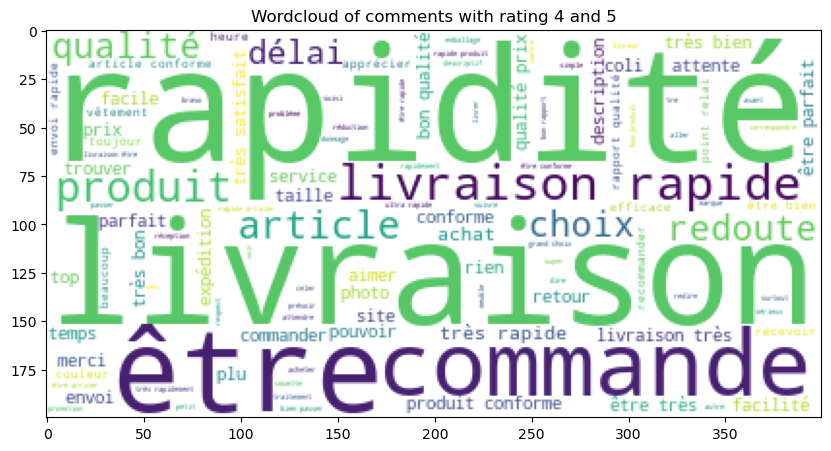

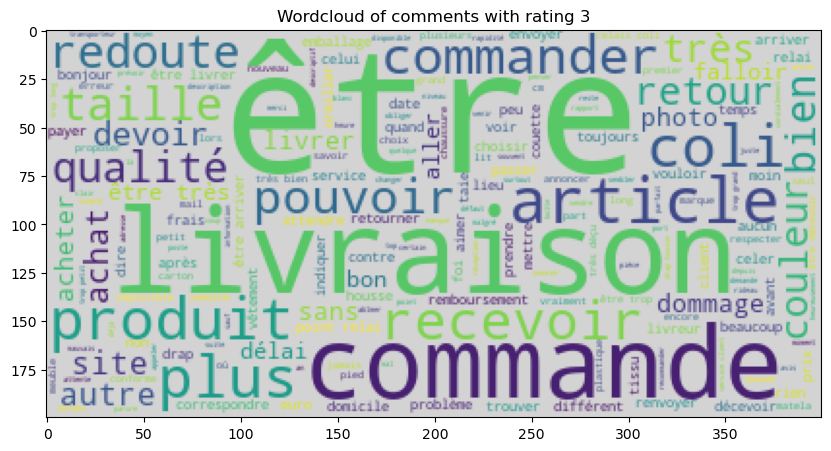

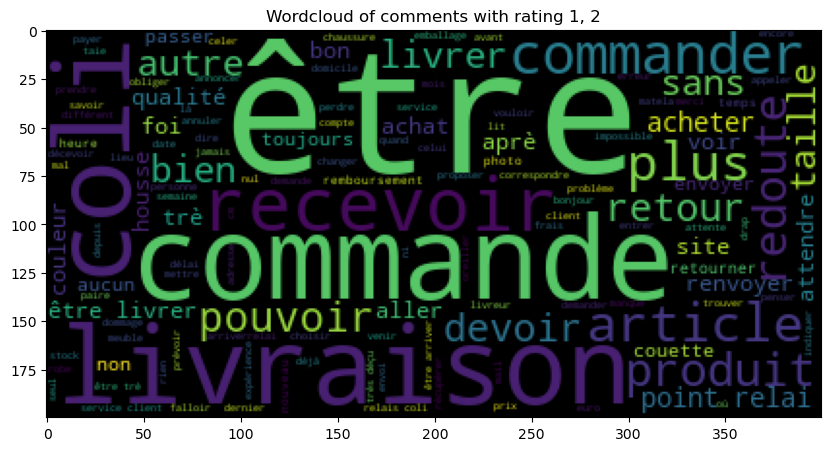

In [13]:
all_comments = ' '.join(data["comment_lemmatized"])
text4plus = ' '.join(data[data["rating"]>=4]["comment_lemmatized"])
text3 = ' '.join(data[data["rating"]==3]["comment_lemmatized"])
text2minus = ' '.join(data[data["rating"]<=2]["comment_lemmatized"])

# Word cloud of all comments
#plot_word_cloud(all_comments, "Wordcloud of all comments")

# Word cloud of comments with rating >=4
plot_word_cloud(text4plus, "Wordcloud of comments with rating 4 and 5")

# Word cloud of comments with rating =3
plot_word_cloud(text3, "Wordcloud of comments with rating 3", "lightgrey")

# Word cloud of comments with rating <=2
plot_word_cloud(text2minus, "Wordcloud of comments with rating 1, 2", "black")

## Sentiment Analysis

In [14]:
## setup
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [15]:
# Sentiment with TextBlob
def tb_sentiment_score(txt):
    return tb(txt).sentiment[0]

def tb_sentiment(txt):
    x = tb_sentiment_score(txt)
    if (x > 0):
        return "Positif"
    elif x == 0:
        return "Neutre"
    else :
        return "Negatif"        

In [16]:
# Def sentiment with Vader
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

def vd_sentiment_score(txt):
    return SIA.polarity_scores(txt)["compound"]

def vd_sentiment(txt):
    x = vd_sentiment_score(txt)
    if (x > 0):
        return "Positif"
    elif x == 0:
        return "Neutre"
    else :
        return "Negatif"        

In [17]:
# Evaluate sentiment for all comments

##Sentiment with TextBlob - fr

#without lemma
data["tb_sentiment_score"] = data["comment_cleaned"].apply(tb_sentiment_score)
data["tb_sentiment"] = data["comment_cleaned"].apply(tb_sentiment)

#with lemma
data["tb_lm_sentiment_score"] = data["comment_lemmatized"].apply(tb_sentiment_score)
data["tb_lm_sentiment"] = data["comment_lemmatized"].apply(tb_sentiment)

#without cleaning and without lemma
data["tbr_sentiment_score"] = data["comment"].apply(tb_sentiment_score)
data["tbr_sentiment"] = data["comment"].apply(tb_sentiment)

data["tbr_lm_sentiment_score"] = data["comment"].apply(tb_sentiment_score)
data["tbr_lm_sentiment"] = data["comment"].apply(tb_sentiment)

##Sentiment with vaderSentiment_fr

#without lemma
data["vd_sentiment_score"] = data["comment_cleaned"].apply(vd_sentiment_score)
data["vd_sentiment"] = data["comment_cleaned"].apply(vd_sentiment)

#with lemma
data["vd_lm_sentiment_score"] = data["comment_lemmatized"].apply(vd_sentiment_score)
data["vd_lm_sentiment"] = data["comment_lemmatized"].apply(vd_sentiment)

#without lemma
data["vdr_sentiment_score"] = data["comment"].apply(vd_sentiment_score)
data["vdr_sentiment"] = data["comment"].apply(vd_sentiment)

#with lemma
data["vdr_lm_sentiment_score"] = data["comment"].apply(vd_sentiment_score)
data["vdr_lm_sentiment"] = data["comment"].apply(vd_sentiment)

dfs = data[["rating", "comment", "comment_cleaned", "comment_lemmatized", 
            "tb_sentiment_score", "tb_lm_sentiment_score", 
            "vd_sentiment_score", "vd_lm_sentiment_score", 
            "tb_sentiment", "vd_sentiment", 
            "tb_lm_sentiment", "vd_lm_sentiment", 
            "tbr_sentiment_score", "tbr_lm_sentiment_score",
            "vdr_sentiment_score", "vdr_lm_sentiment_score",
            "tbr_sentiment", "vdr_sentiment", 
            "tbr_lm_sentiment", "vdr_lm_sentiment",
            "createdAt"]]
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23469 entries, 0 to 23468
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rating                  23469 non-null  int64  
 1   comment                 23469 non-null  object 
 2   comment_cleaned         23469 non-null  object 
 3   comment_lemmatized      23469 non-null  object 
 4   tb_sentiment_score      23469 non-null  float64
 5   tb_lm_sentiment_score   23469 non-null  float64
 6   vd_sentiment_score      23469 non-null  float64
 7   vd_lm_sentiment_score   23469 non-null  float64
 8   tb_sentiment            23469 non-null  object 
 9   vd_sentiment            23469 non-null  object 
 10  tb_lm_sentiment         23469 non-null  object 
 11  vd_lm_sentiment         23469 non-null  object 
 12  tbr_sentiment_score     23469 non-null  float64
 13  tbr_lm_sentiment_score  23469 non-null  float64
 14  vdr_sentiment_score     23469 non-null

In [18]:
# zoom_in function to look in detail
def zoom_in(dfs, i):
    print("rating:", dfs.iloc[i,0], " ** tb:", dfs.iloc[i,4], "** tblm:", dfs.iloc[i,5], "** vd:", 
          dfs.iloc[i,6], "** vdlm:", dfs.iloc[i,7], "\n",
          " ** tbr:", dfs.iloc[i,12], "** tbrlm:", dfs.iloc[i,13], " ** vdr:", dfs.iloc[i,14], "** vdrlm:", dfs.iloc[i,15], "\n")
    print(dfs.iloc[i,1], "\n")
    print(dfs.iloc[i,2], "\n") 
    print(dfs.iloc[i,3], "\n")

In [19]:
# let's in detail the comment N°3 with Rating 4 and "Negatif" sentiment. 
zoom_in(dfs, 3)

rating: 4  ** tb: -0.010454545454545454 ** tblm: -0.03318181818181817 ** vd: 0.6015 ** vdlm: -0.5106 
  ** tbr: -0.010454545454545454 ** tbrlm: -0.010454545454545454  ** vdr: 0.6015 ** vdrlm: 0.6015 

je commande depuis longtemps chez la redoute; j'y appréciais le choix , la rapidité de livraison et la facilité de règlement grace à la carte ,meme si presque  a chaque fois je demandais un règlement comptant cela m'évitait de laisser mon numéro de carte bleue  sur le web ...par contre depuis quelques jours cela a changé je n'y comprends plus rien je ne peux plus payer comme ça alors que  je n'ai absolument  aucun débit  en attente sur mon compte ....du coup par sécurité face a l'internet  j'ai dû régler  mes deux dernières commandes avec une carte bancaire à usage unique ce qui est un peu  plus compliqué pour moi et risque  forcement de me faire hésiter pour des   futurs  achats sur ce site....dommage. 

je commande depuis longtemps chez la redoute; j'y appréciais le choix , la rapidité 

#### Interesting observation captured by the model
The comment N°3 with rating 4 and sentiment = "Negatif" is indeed in a negative tone although the rating is 4.
The comment is indeed negatif since :
- the cutomer is complaining about security risk regard the credit card number
- the customer also announced that in the future, he'll hesitate to buy from la Redoute website because of the issue



In [20]:
dfz = dfs[(dfs["rating"] == 3) & (dfs["tb_sentiment_score"]==0)]
for i in range(10, 20):
    print("row " + str(i)+":")
    zoom_in(dfz, i)

row 10:
rating: 3  ** tb: 0.0 ** tblm: 0.0 ** vd: 0.0772 ** vdlm: -0.2263 
  ** tbr: 0.0 ** tbrlm: 0.0  ** vdr: 0.0772 ** vdrlm: 0.0772 

Il manquait un article dans mon colis. J'attends le retour du service apres-vente 

il manquait un article dans mon colis. j'attends le retour du service apres-vente  

il manquer un article dans mon colis . je attendre le retour de service apres-vente  

row 11:
rating: 3  ** tb: 0.0 ** tblm: 0.0 ** vd: 0.0 ** vdlm: 0.0 
  ** tbr: 0.0 ** tbrlm: 0.0  ** vdr: 0.0 ** vdrlm: 0.0 

Sans étiquette de retour intégrée au paquet ,je ne peux faire aucun renvoi… 

sans étiquette de retour intégrée au paquet ,je ne peux faire aucun renvoi…  

sans étiquette de retour intégrer au paquet , je ne pouvoir faire aucun renvoi …  

row 12:
rating: 3  ** tb: 0.0 ** tblm: 0.0 ** vd: 0.0 ** vdlm: 0.0 
  ** tbr: 0.0 ** tbrlm: 0.0  ** vdr: 0.0 ** vdrlm: 0.0 

Colis abîmé à la livraison. Je ne ferai pas de retour car je vais reparer 

colis abîmé à la livraison. je ne ferai

## Sentiment Score Comparison between TextBlob, Vader sentiment eval with lemma and without lemma

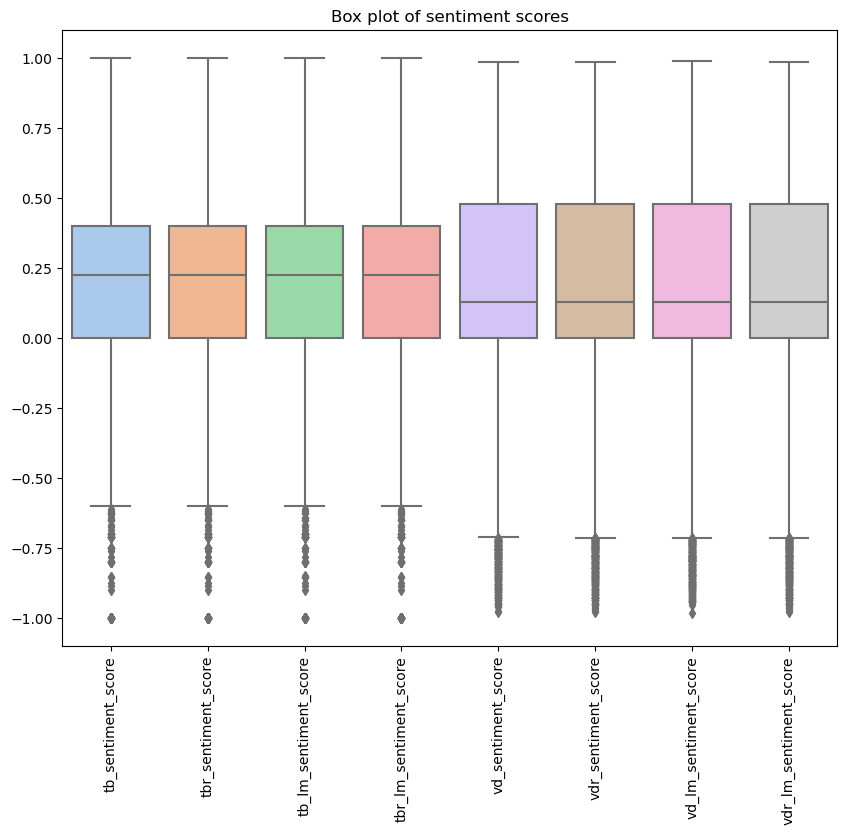

In [21]:
# Box plot of sentiment scores 
sent_scores = ['tb_sentiment_score', 'tbr_sentiment_score', 'tb_lm_sentiment_score', 'tbr_lm_sentiment_score' , 
               'vd_sentiment_score', 'vdr_sentiment_score', 'vd_lm_sentiment_score', 'vdr_lm_sentiment_score']
plt.figure(figsize = (10,8))
sns.boxplot(data = data[sent_scores], palette = "pastel")
plt.title("Box plot of sentiment scores")
plt.xticks(rotation = 90)
plt.show()

In [22]:
dfs.columns

Index(['rating', 'comment', 'comment_cleaned', 'comment_lemmatized',
       'tb_sentiment_score', 'tb_lm_sentiment_score', 'vd_sentiment_score',
       'vd_lm_sentiment_score', 'tb_sentiment', 'vd_sentiment',
       'tb_lm_sentiment', 'vd_lm_sentiment', 'tbr_sentiment_score',
       'tbr_lm_sentiment_score', 'vdr_sentiment_score',
       'vdr_lm_sentiment_score', 'tbr_sentiment', 'vdr_sentiment',
       'tbr_lm_sentiment', 'vdr_lm_sentiment', 'createdAt'],
      dtype='object')

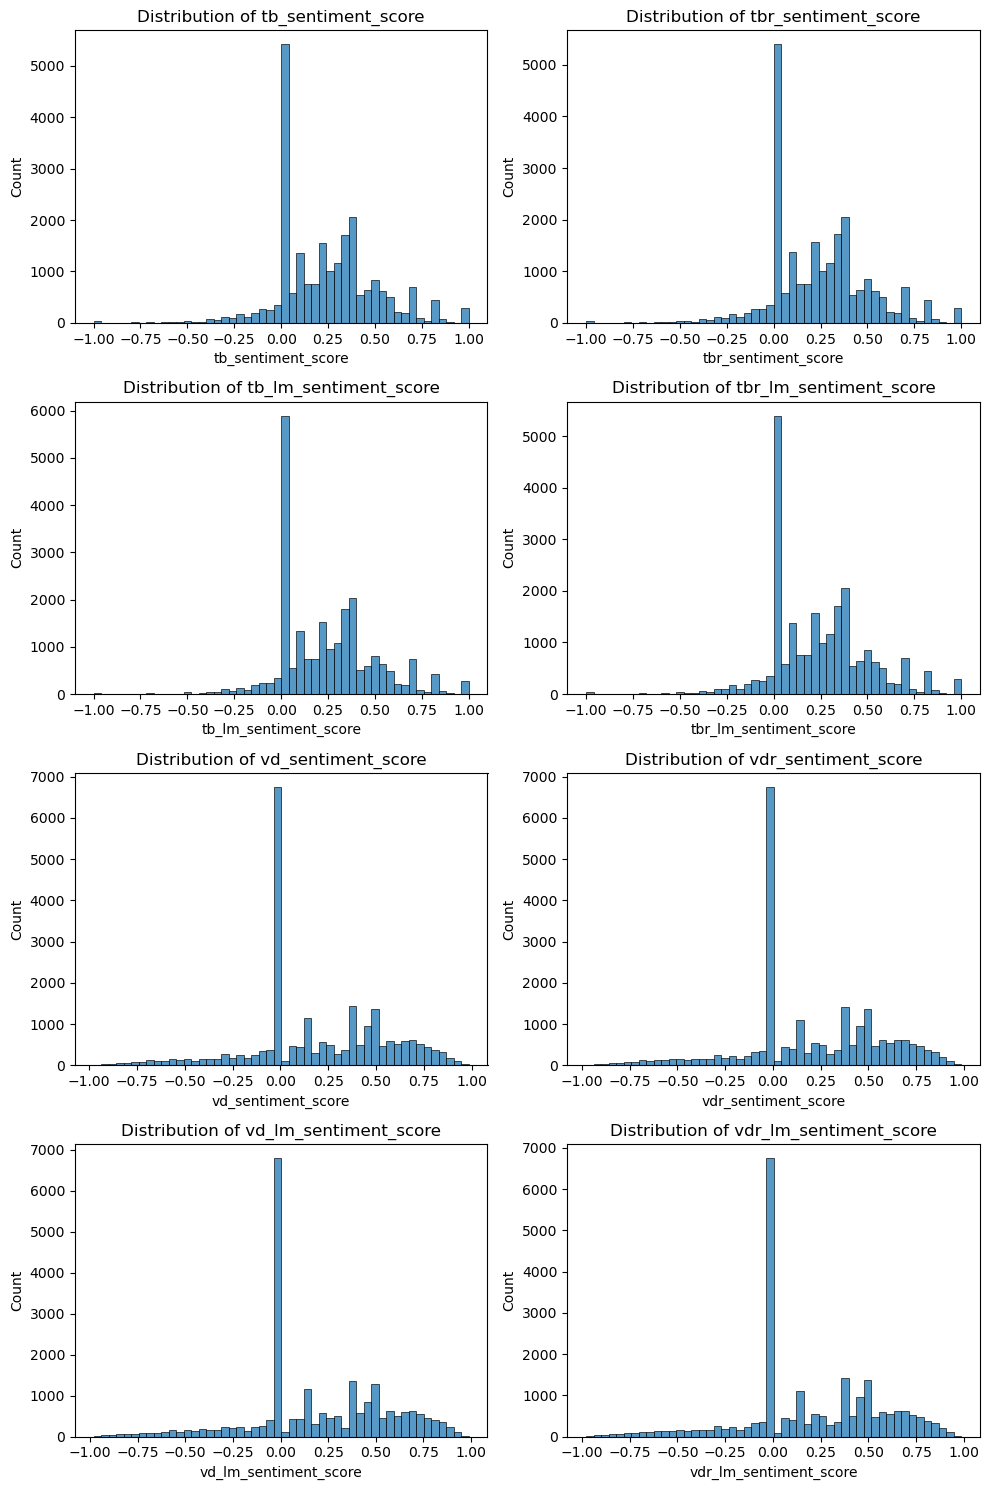

In [23]:
# Distribution of sentiment scores for textBlob and Vender sentiment analysis with lemma and without lemma

sent_scores = ['tb_sentiment_score', 'tbr_sentiment_score', 'tb_lm_sentiment_score', 'tbr_lm_sentiment_score' , 
               'vd_sentiment_score', 'vdr_sentiment_score', 'vd_lm_sentiment_score', 'vdr_lm_sentiment_score']
j = 0
plt.figure(figsize=(10,15))
for sent_score in sent_scores:
    j = j + 1
    plt.subplot(4,2,j)
    sns.histplot(data=dfs, x = sent_score, bins = 50)
    plt.title("Distribution of {}".format(sent_score))
plt.tight_layout()  
plt.show()


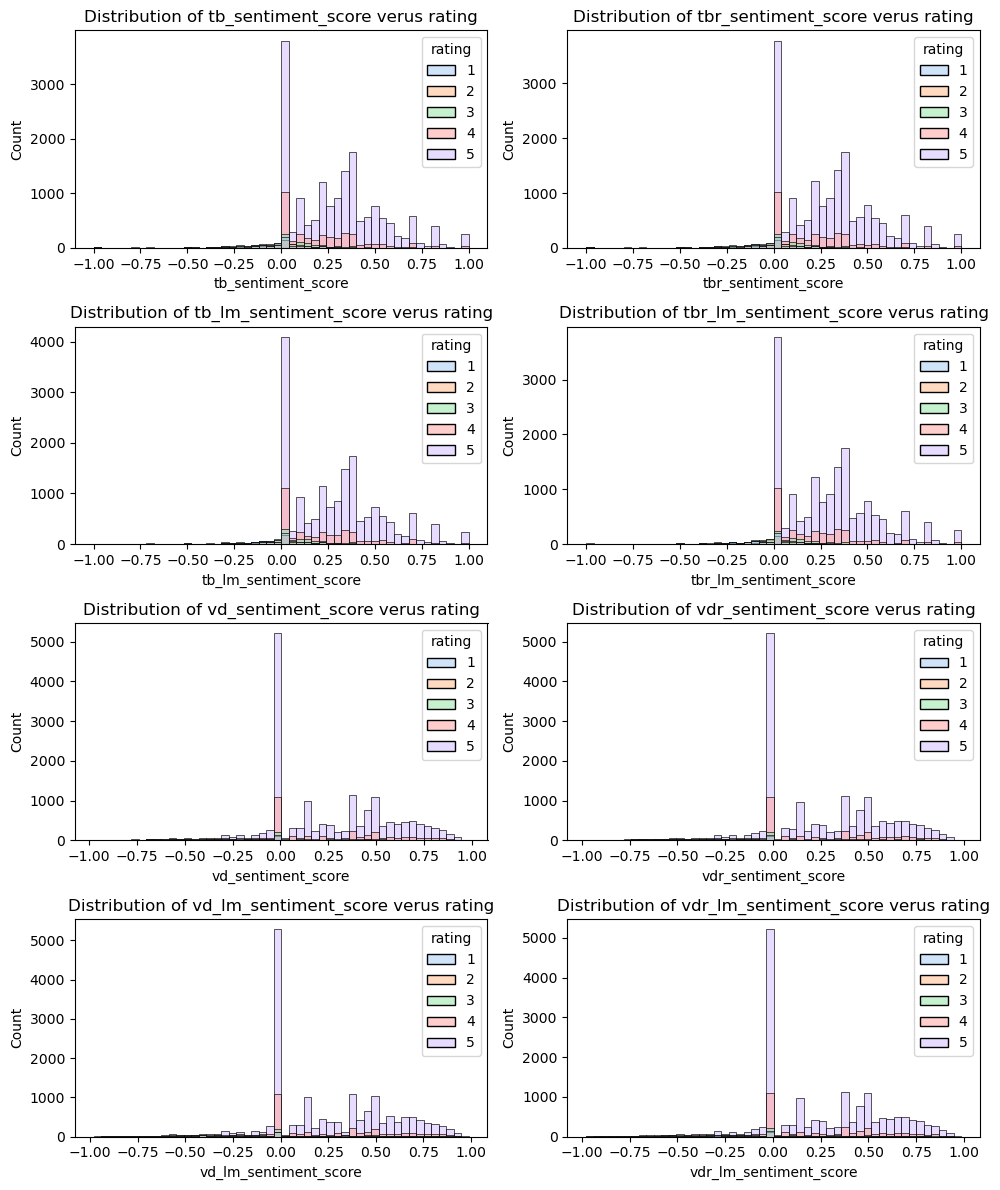

In [24]:
# Histogram of sentiment scores versus rating
j = 0
plt.figure(figsize=(10,12))
for sent_score in sent_scores:
    j = j + 1
    plt.subplot(4,2,j)
    sns.histplot(data=dfs, x = sent_score, hue = "rating", bins = 50, palette = "pastel")
    plt.title("Distribution of {} verus rating".format(sent_score))
plt.tight_layout()
plt.show()
   

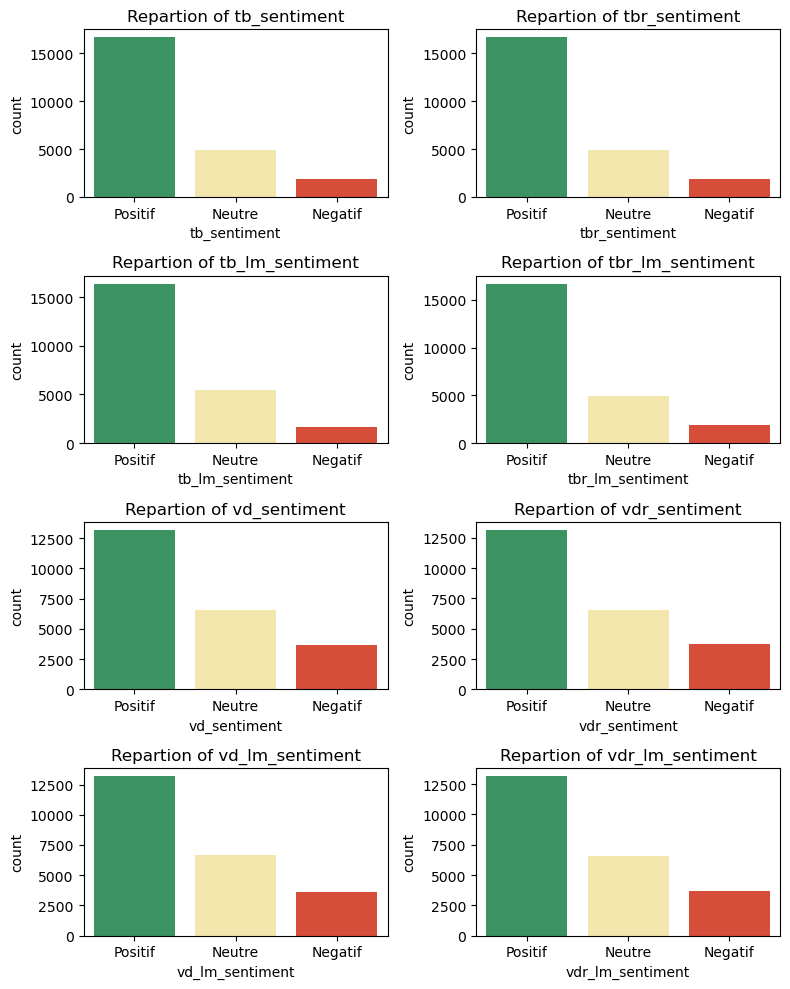

In [25]:
# Proportion of sentiment "Positif", "Neutre", "Negatif"
# Distribution of sentiment scores for textBlob and Vender sentiment analysis with lemma and without lemma
sents = ['tb_sentiment', 'tbr_sentiment', 'tb_lm_sentiment', 'tbr_lm_sentiment' , 
               'vd_sentiment', 'vdr_sentiment', 'vd_lm_sentiment', 'vdr_lm_sentiment']
j = 0
plt.figure(figsize=(8,10))
s = dfs["tb_sentiment"].value_counts(ascending=False)
color = ["#2ca25f", "#ffeda0", "#f03b20"]
for sent in sents:
    j = j + 1
    plt.subplot(4,2,j)
    sns.countplot(data=dfs, x = sent, order = s.index, palette = color)
    plt.title("Repartion of {}".format(sent))
plt.tight_layout()
plt.show()


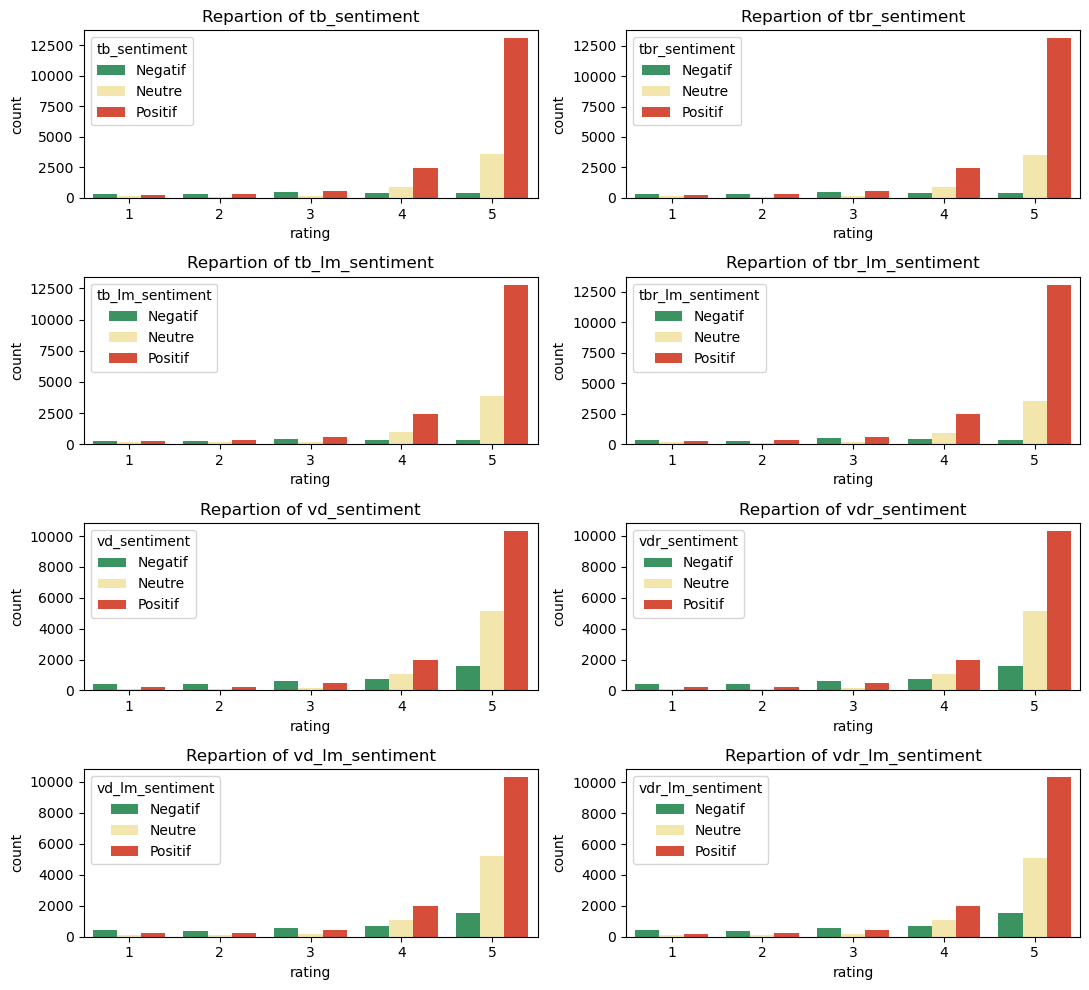

In [26]:
# Proportion of sentiment "Positif", "Neutre", "Negatif" versus rating
sents = ['tb_sentiment', 'tbr_sentiment', 'tb_lm_sentiment', 'tbr_lm_sentiment' , 
               'vd_sentiment', 'vdr_sentiment', 'vd_lm_sentiment', 'vdr_lm_sentiment']

plt.figure(figsize=(11,10))
s = dfs["tb_sentiment"].value_counts(ascending = True)
color = ["#2ca25f", "#ffeda0", "#f03b20"]
j = 0
for sent in sents:
    j = j + 1
    plt.subplot(4,2,j)
    sns.countplot(data=dfs, x = "rating", hue = sent, palette = color, hue_order= s.index)
    plt.title("Repartion of {}".format(sent))
plt.tight_layout()    
plt.show()



In [27]:
df1 = dfs[(dfs["rating"]<=2) & (dfs["vd_sentiment"]== "Positif")]
zoom_in(df1, 0)
#In this case the comment is clearly negative, but the model didn't caputure it. The model tagged it as positive sentiment

rating: 2  ** tb: 0.09538461538461539 ** tblm: 0.14 ** vd: 0.3777 ** vdlm: 0.6119 
  ** tbr: 0.09538461538461539 ** tbrlm: 0.09538461538461539  ** vdr: 0.5355 ** vdrlm: 0.5355 

Le 17 août 2023, j'ai passé la commande n°20232293152880 composée de deux housses de couette, 2 taies d'oreiller et un drap housse. En raison du montant de la commande les frais d'expédition en point relais étaient offerts. Un autre drap housse (Réf. 4585605) que je voulais commander n'était pas alors disponible. Un mois après La Redoute m'informe que ce drap housse est de nouveau en stock. Par téléphone je passe la commande n°20232617038300 en demandant le port gratuit dans la mesure ou cette nouvelle commande n'est pas de mon fait. Mon interlocutrice a refusé. Devant mon insistance elle a sollicité une autre personne : même refus. Si le second drap housse avait été disponible le 17 août, je n'aurais pas eu à payer des frais d'expédition. Je ne comprends pas pourquoi j'ai eu à supporter 4,95 € de frais. Je dem

In [30]:
data.head()


,id,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,...,tbr_lm_sentiment_score,tbr_lm_sentiment,vd_sentiment_score,vd_sentiment,vd_lm_sentiment_score,vd_lm_sentiment,vdr_sentiment_score,vdr_sentiment,vdr_lm_sentiment_score,vdr_lm_sentiment
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,...,0.136923,Positif,-0.2359,Negatif,0.7273,Positif,-0.3662,Negatif,-0.3662,Negatif
1,rev-b54467c4-4769-42e3-a74a-c72c000059f9,4,Jolie table mais plus pour 6 que pour 8,Livraison impeccable avec possibilité de prend...,2023-10-02 13:08:27,2023-09-11,NaN,NaN,2023-10-02,2023,...,0.172812,Positif,0.3962,Positif,0.6287,Positif,0.5032,Positif,0.5032,Positif
2,rev-b480f537-524e-491e-9f85-74405332c047,4,Achat d'un canapé La Redoute intérieurs…,Achat d'un canapé La Redoute intérieurs le 6/9...,2023-09-18 16:52:21,2023-09-06,NaN,NaN,2023-09-18,2023,...,0.160714,Positif,0.8382,Positif,0.6650,Positif,0.8785,Positif,0.8785,Positif
3,rev-f04626f5-846d-41ca-9866-46573746f75b,4,excellent site mais des changements qui compl...,je commande depuis longtemps chez la redoute; ...,2023-10-13 08:57:16,2023-10-02,NaN,NaN,2023-10-13,2023,...,-0.010455,Negatif,0.6015,Positif,-0.5106,Negatif,0.6015,Positif,0.6015,Positif
4,rev-d3bb4eb5-ea0f-45db-afb5-313eaeaed6cb,5,"Comme d'habitude, aucun souci et rapidité d'ex...","Comme d'habitude, aucun souci et rapidité d'ex...",2023-09-21 11:09:15,2023-09-15,NaN,NaN,2023-09-21,2023,...,0.037500,Positif,0.4567,Positif,0.6796,Positif,0.7086,Positif,0.7086,Positif


In [35]:
data["vader_sentiment"] = 1*(data["vd_sentiment_score"] > 0)
data["textblob_sentiment"] = 1*(data["tbr_sentiment_score"] > 0)
data["rating_sentiment"] =  1*(data["rating"] >= 4)
data.head(1)

,id,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,...,vd_lm_sentiment_score,vd_lm_sentiment,vdr_sentiment_score,vdr_sentiment,vdr_lm_sentiment_score,vdr_lm_sentiment,vader_sentiment,rating_sentiment,textblox_sentiment,textblob_sentiment
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,...,0.7273,Positif,-0.3662,Negatif,-0.3662,Negatif,0,1,1,1


### Remarque :
- <b>Vader détecte mieux les rating négatifs que TexBlob<b>

- <b>Texblob détecte mieux les rating positifs</b>


In [41]:
# matrices de confusion
vs = data["vader_sentiment"]
ts = data["textblob_sentiment"]
rs = data["rating_sentiment"]

print("**** Matrice de confusion Vader versus Rating ****")
display(pd.crosstab(rs, vs, rownames=["Rating"], colnames = ["Vader"]))

print("**** Classification report ****")
print(metrics.classification_report(rs, vs))

print("**** Matrice de confusion TextBlob versus Rating ****")
display(pd.crosstab(rs, ts, rownames=["Rating"], colnames = ["Textblob"]))

print("**** Classification report ****")
print(metrics.classification_report(rs, ts))

print("**** Matrice de confusion Vader versus Textblob ****")
display(pd.crosstab(ts, vs, rownames=["TextBlob"], colnames = ["Vader"]))

print("**** Classification report ****")
print(metrics.classification_report(ts, vs))

**** Matrice de confusion Vader versus Rating ****


Vader,0,1
Rating,,
0,1820,880
1,8470,12299


**** Classification report ****
              precision    recall  f1-score   support

           0       0.18      0.67      0.28      2700
           1       0.93      0.59      0.72     20769

    accuracy                           0.60     23469
   macro avg       0.56      0.63      0.50     23469
weighted avg       0.85      0.60      0.67     23469

**** Matrice de confusion TextBlob versus Rating ****


Textblob,0,1
Rating,,
0,1553,1147
1,5223,15546


**** Classification report ****
              precision    recall  f1-score   support

           0       0.23      0.58      0.33      2700
           1       0.93      0.75      0.83     20769

    accuracy                           0.73     23469
   macro avg       0.58      0.66      0.58     23469
weighted avg       0.85      0.73      0.77     23469

**** Matrice de confusion Vader versus Textblob ****


Vader,0,1
TextBlob,,
0,4550,2226
1,5740,10953


**** Classification report ****
              precision    recall  f1-score   support

           0       0.44      0.67      0.53      6776
           1       0.83      0.66      0.73     16693

    accuracy                           0.66     23469
   macro avg       0.64      0.66      0.63     23469
weighted avg       0.72      0.66      0.68     23469



## Zooming

In [ ]:

dfs.info()

In [ ]:
Z = data["tbr_lm_sentiment_score"]
ds_zero = data[Z == 0]
x = len(ds_zero)/len(data)
print("Après Lemmatization, {:.2%} des commentaires ont un sentiment_score null".format(x))

In [ ]:
Z2 = data["sentiment_score"]
ds2_zero = data[Z2 == 0]
x = len(ds2_zero)/len(data)
print("Sans lemmatization, {:.2%} des commentaires ont un sentiment_score null".format(x))

In [ ]:
sns.countplot(data=ds_zero, x = "rating", palette = "pastel")
plt.title("Rating distribution of comments with sentiment_score = 0");


In [ ]:
def zoom_in(i):
    print("rating:", ds_zero.iloc[i,1])
    #print("lem_sentiment_score:", ds_zero.iloc[i,29])
    print("sentiment_score:", ds_zero.iloc[i,27])
    print("comment_cleaned:", ds_zero.iloc[i,25])
    print(ds_zero.iloc[i,26])
    print(ds_zero.iloc[i,3])

for i in [6, 7, 8, 9, 25]:
    zoom_in(i)
    print("\n")


In [ ]:
print("rating:", ds_zero.iloc[5,1])
print("lem_sentiment_score:", ds_zero.iloc[5,29])
print("sentiment_score:", ds_zero.iloc[5,27])
print(ds_zero.iloc[5,26])
print(ds_zero.iloc[5,3])

In [ ]:
ds_zero.info()